In [1]:
import pandas as pd
import numpy as np
df_geral = pd.read_csv('df_analise_geral.csv')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
import seaborn as sns

C:\Users\Raul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_geral.head()

,AnoMes,VL Tabela,Vl Bruto,Vl Liquido Final,Clientes,Veiculos,UENs,Setores,Origem,IPCA BR,IPCA ES,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES,PMC - Número-índice (2022=100) (Número-índice)/ BR,PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ ES,PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ BR,"PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ ES","PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ BR"
0,2020-01,9167549.37,6472828.52,5393691.53,583,19,3,33,6,0.21,0.29,1.1,84.25384,95.01804,87.06581,97.86726,1.8,-1.9
1,2020-02,10118763.18,7254142.47,5751548.26,559,19,3,39,6,0.25,0.33,1.1,81.61827,90.61413,86.78925,98.12855,-0.3,0.3
2,2020-03,10169765.90,7311965.44,5894599.74,558,19,3,36,6,0.07,0.12,1.1,80.76074,90.34239,83.15137,93.91747,-4.2,-4.3
3,2020-04,6490599.70,4774743.44,3931148.87,442,18,3,36,6,-0.31,-0.09,-1.7,66.43382,75.01668,69.94442,79.16208,-15.9,-15.7
4,2020-05,6883611.73,4887930.28,3993915.02,371,19,3,31,6,-0.38,-0.48,-1.7,81.57634,86.89620,82.56763,88.37704,18.0,11.6


In [33]:
df_geral.shape

(54, 22)

In [5]:
# Criando a coluna 'Ano'
df_geral['Ano'] = df_geral['AnoMes'].str[:4]

# Criando a coluna 'Mes'
df_geral['Mes'] = df_geral['AnoMes'].str[5:].astype(int)

# Criando a coluna 'Semestre' (primeiro semestre = 1, segundo semestre = 2)
df_geral['Semestre'] = df_geral['Mes'].apply(lambda x: 1 if x <= 6 else 2)

# Criando a coluna 'Mes do Semestre' (de 1 a 6, sempre)
df_geral['Mes do Semestre'] = df_geral['Mes'].apply(lambda x: x if x <= 6 else x - 6)

# Exibindo o DataFrame atualizado
df_geral.head(15)

,AnoMes,VL Tabela,Vl Bruto,Vl Liquido Final,Clientes,Veiculos,UENs,Setores,Origem,IPCA BR,...,PMC - Número-índice (2022=100) (Número-índice)/ ES,PMC - Número-índice (2022=100) (Número-índice)/ BR,PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ ES,PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ BR,"PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ ES","PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ BR",Ano,Mes,Semestre,Mes do Semestre
0,2020-01,9167549.37,6472828.52,5393691.53,583,19,3,33,6,0.21,...,84.25384,95.01804,87.06581,97.86726,1.8,-1.9,2020,1,1,1
1,2020-02,10118763.18,7254142.47,5751548.26,559,19,3,39,6,0.25,...,81.61827,90.61413,86.78925,98.12855,-0.3,0.3,2020,2,1,2
2,2020-03,10169765.90,7311965.44,5894599.74,558,19,3,36,6,0.07,...,80.76074,90.34239,83.15137,93.91747,-4.2,-4.3,2020,3,1,3
3,2020-04,6490599.70,4774743.44,3931148.87,442,18,3,36,6,-0.31,...,66.43382,75.01668,69.94442,79.16208,-15.9,-15.7,2020,4,1,4
4,2020-05,6883611.73,4887930.28,3993915.02,371,19,3,31,6,-0.38,...,81.57634,86.89620,82.56763,88.37704,18.0,11.6,2020,5,1,5
5,2020-06,7653136.26,5544746.12,4500465.96,409,19,3,31,6,0.26,...,83.31604,91.20908,88.39614,95.16073,7.1,7.7,2020,6,1,6
6,2020-07,8202808.40,5632670.95,4593350.65,448,19,3,34,6,0.36,...,89.13238,99.06405,88.73469,99.56395,0.4,4.6,2020,7,2,1
7,2020-08,9602968.55,6598670.37,5238599.75,531,19,3,39,6,0.24,...,90.26367,102.25301,90.99657,102.33392,2.5,2.8,2020,8,2,2
8,2020-09,9741010.51,6179060.58,5058580.11,512,19,3,39,6,0.64,...,90.83188,99.17828,93.48728,103.47595,2.7,1.1,2020,9,2,3
9,2020-10,12428071.04,8314370.94,6784657.89,609,19,3,42,6,0.86,...,99.50737,105.88980,96.57693,104.42429,3.3,0.9,2020,10,2,4


In [8]:
df_geral.dtypes

AnoMes                                                                                object
VL Tabela                                                                            float64
Vl Bruto                                                                             float64
Vl Liquido Final                                                                     float64
Clientes                                                                               int64
Veiculos                                                                               int64
UENs                                                                                   int64
Setores                                                                                int64
Origem                                                                                 int64
IPCA BR                                                                              float64
IPCA ES                                                               

In [12]:
df_datas = df_geral.drop(columns=['AnoMes', 'VL Tabela', 'Vl Bruto', 'Clientes', 'Veiculos', 'UENs', 'Setores', 'Origem', 'IPCA BR', 'IPCA ES', 'Taxa Ac. TRI % PIB', 'PMC - Número-índice (2022=100) (Número-índice)/ ES', 'PMC - Número-índice (2022=100) (Número-índice)/ BR', 'PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ ES', 'PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ BR', 'PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ ES', 'PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ BR', 'Mes'])

In [13]:
df_datas.head()

,Vl Liquido Final,Ano,Semestre,Mes do Semestre
0,5393691.53,2020,1,1
1,5751548.26,2020,1,2
2,5894599.74,2020,1,3
3,3931148.87,2020,1,4
4,3993915.02,2020,1,5


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [15]:
# Separar variáveis independentes (features) e dependente (target)
X = df_datas[['Ano', 'Semestre', 'Mes do Semestre']]
y = df_datas['Vl Liquido Final']

In [17]:
# Dividir os dados em conjunto de treino e teste (usando 80% para treino e 20% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Criar o modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Treinar o modelo com os dados de treino
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [50]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
   ---------- ----------------------------- 122.9/456.2 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 456.2/456.2 kB 5.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------ --------------------------------- 0.4/2.7 MB 8.5 MB/s eta 0:00:01
   ------------ --------------------------- 0.8/2.7 MB 13.0 MB/s eta 0:00:01
   -------------------- ------------------- 1.4/2.7 MB 11.1 MB/s eta 0:00:01
   ------------------------------- -------- 2.1/2.7 MB 13.6 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 12.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   - -------------------------------------- 0.8/28.1 MB 27.1 MB/s eta 0:00:02
   -- ------------------------------------- 1.5/28.1 MB 18.6 MB/s eta 0:00:02
   --- -----


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: C:\Users\Raul\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


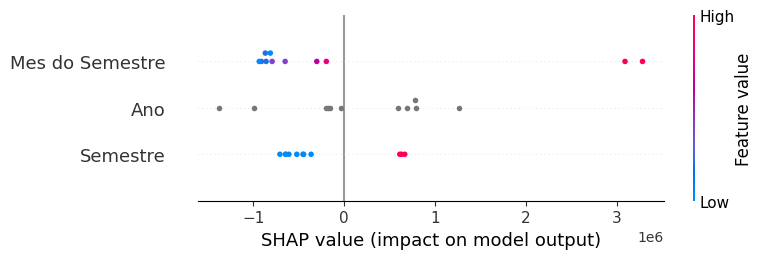

In [51]:
import shap

# Criar um objeto explicador usando o modelo treinado
explainer = shap.TreeExplainer(model)

# Calcular os valores SHAP para o conjunto de teste
shap_values = explainer.shap_values(X_test)

# Exibir os valores SHAP para um resumo
shap.summary_plot(shap_values, X_test)

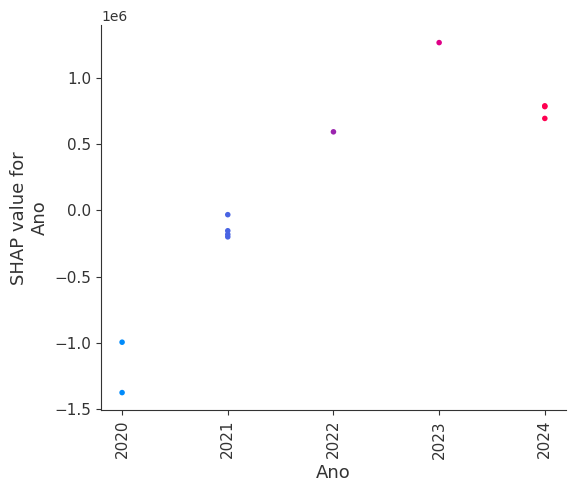

In [54]:
shap.dependence_plot(0, shap_values, X_test)


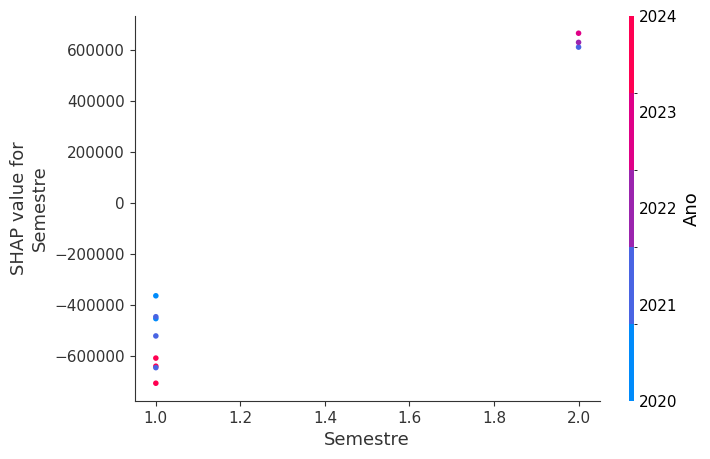

In [55]:
shap.dependence_plot(1, shap_values, X_test)


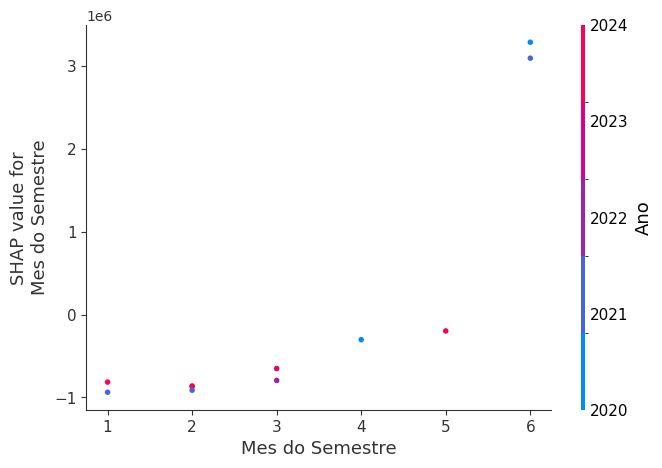

In [56]:
shap.dependence_plot(2, shap_values, X_test)


In [19]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo usando o erro quadrático médio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f'Erro Quadrático Médio (MSE): {mse}')

Erro Quadrático Médio (MSE): 3724631785622.5293


In [20]:
# Prever o valor líquido final para os dados existentes
y_pred_all = model.predict(X)

# Adicionar as previsões ao DataFrame original
df_datas['Previsao'] = y_pred_all

In [34]:
df_datas.shape

(54, 7)

In [29]:
# Supondo que o 'Mes do Semestre' varia de 1 a 6, onde:
# 1-6 correspondem ao primeiro semestre (jan-jun) e 1-6 no segundo semestre (jul-dez).

# Ajustar o mês com base no semestre
df_datas['Mês Corrigido'] = df_datas.apply(
    lambda x: x['Mes do Semestre'] if x['Semestre'] == 1 else x['Mes do Semestre'] + 6,
    axis=1
)

# Criar a nova coluna de data assumindo o primeiro dia de cada mês
df_datas['Data'] = pd.to_datetime(df_datas.rename(columns={'Ano': 'year', 'Mês Corrigido': 'month'}).assign(day=1)[['year', 'month', 'day']])

# Verificar os dados com a nova coluna 'Data'
df_datas.head()


,Vl Liquido Final,Ano,Semestre,Mes do Semestre,Previsao,Data,Mês Corrigido
0,5393691.53,2020,1,1,5.420609e+06,2020-01-01,1
6,4593350.65,2020,2,1,4.887636e+06,2020-07-01,7
1,5751548.26,2020,1,2,5.664023e+06,2020-02-01,2
7,5238599.75,2020,2,2,5.239738e+06,2020-08-01,8
8,5058580.11,2020,2,3,5.355226e+06,2020-09-01,9


In [38]:
df_datas['Data'].value_counts()

Data
2020-01-01    1
2023-09-01    1
2022-03-01    1
2022-04-01    1
2022-10-01    1
2022-05-01    1
2022-11-01    1
2022-12-01    1
2022-06-01    1
2023-01-01    1
2023-07-01    1
2023-02-01    1
2023-08-01    1
2023-03-01    1
2020-07-01    1
2023-04-01    1
2023-10-01    1
2023-05-01    1
2023-11-01    1
2023-12-01    1
2023-06-01    1
2024-01-01    1
2024-02-01    1
2024-03-01    1
2024-04-01    1
2024-05-01    1
2022-09-01    1
2022-02-01    1
2022-08-01    1
2022-07-01    1
2020-02-01    1
2020-08-01    1
2020-09-01    1
2020-03-01    1
2020-04-01    1
2020-10-01    1
2020-11-01    1
2020-05-01    1
2020-06-01    1
2020-12-01    1
2021-01-01    1
2021-07-01    1
2021-08-01    1
2021-02-01    1
2021-09-01    1
2021-03-01    1
2021-04-01    1
2021-10-01    1
2021-05-01    1
2021-11-01    1
2021-12-01    1
2021-06-01    1
2022-01-01    1
2024-06-01    1
Name: count, dtype: int64

In [30]:
mape = (abs((df_datas['Vl Liquido Final'] - df_datas['Previsao']) / df_datas['Vl Liquido Final'])).mean() * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 8.77%


In [40]:
print(df_datas.dtypes)


Vl Liquido Final    float64
Ano                  object
Semestre              int64
Mes do Semestre       int64
Previsao            float64
Mês Corrigido         int64
dtype: object


In [44]:
df_datas['Ano'] = pd.to_numeric(df_datas['Ano'], errors='coerce')


C:\Users\Raul\AppData\Local\Temp\ipykernel_11420\3130507612.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_filtrado = df_datas.resample('2M').mean()


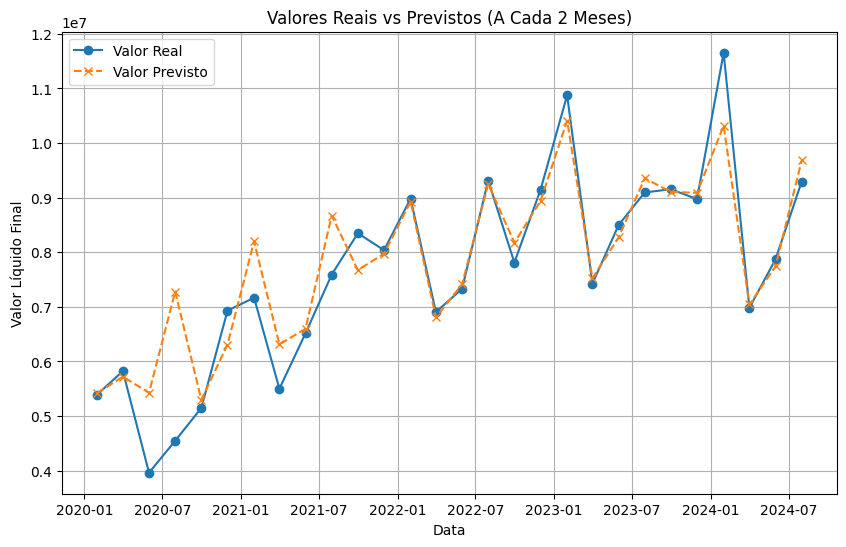

In [48]:
# Certificar-se de que a coluna 'Data' está no formato datetime
#df_datas['Data'] = pd.to_datetime(df_datas['Data'])

# Definir 'Data' como índice
#df_datas.set_index('Data', inplace=True)

# Amostrar os dados a cada 2 meses (M significa mês, e '2M' a cada 2 meses)
df_filtrado = df_datas.resample('2M').mean()

# Plotar os valores reais e previstos ao longo do tempo (a cada 2 meses)
plt.figure(figsize=(10, 6))
plt.plot(df_filtrado.index, df_filtrado['Vl Liquido Final'], label='Valor Real', marker='o')
plt.plot(df_filtrado.index, df_filtrado['Previsao'], label='Valor Previsto', marker='x', linestyle='--')

# Configurar o gráfico
plt.title('Valores Reais vs Previstos (A Cada 2 Meses)')
plt.xlabel('Data')
plt.ylabel('Valor Líquido Final')
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()


In [ ]:
df_datas

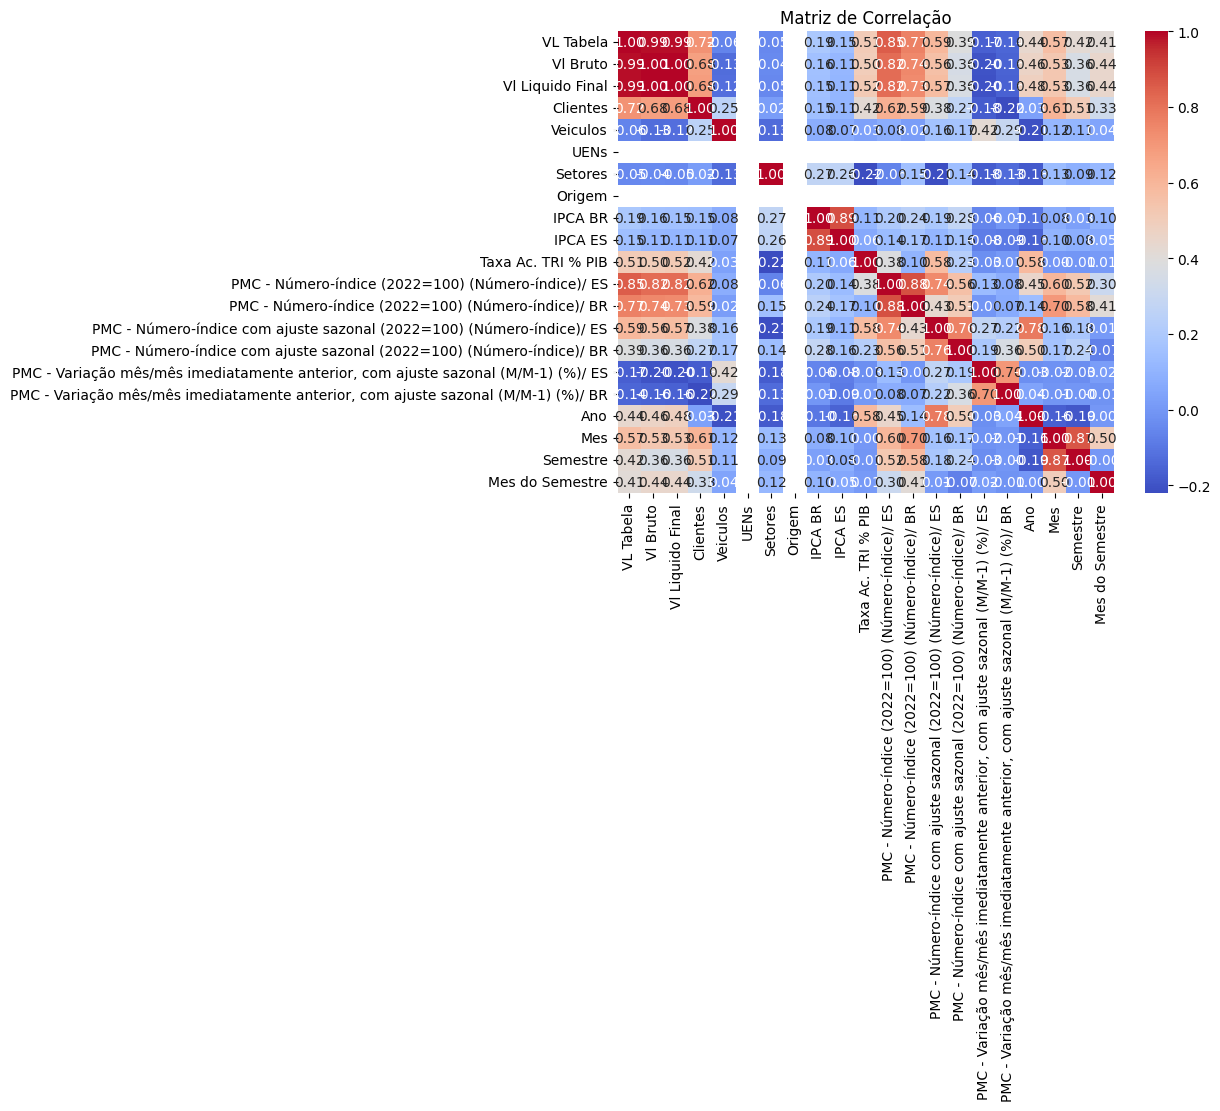

In [7]:
df_geral_corr = df_geral.drop(columns=['AnoMes'])
correlation_matrix = df_geral_corr.corr()

# Exibindo a matriz de correlação com Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [4]:
df_geral.tail()

,AnoMes,VL Tabela,Vl Bruto,Vl Liquido Final,Clientes,Veiculos,UENs,Setores,Origem,IPCA BR,IPCA ES,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES,PMC - Número-índice (2022=100) (Número-índice)/ BR,PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ ES,PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ BR,"PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ ES","PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ BR"
49,2024-02,12047523.41,8633683.15,7113309.70,436,18,3,39,6,0.83,0.70,2.5,92.67579,96.46589,101.07075,105.09956,-1.3,1.0
50,2024-03,11750804.42,8290217.09,6848047.67,467,19,3,36,6,0.16,0.05,2.5,103.20858,106.00817,103.42005,105.36516,2.3,0.3
51,2024-04,12583444.11,9243291.24,7667461.96,527,19,3,40,6,0.38,0.43,2.5,98.85368,99.68929,104.66221,106.28871,1.2,0.9
52,2024-05,13388107.38,9696920.43,8076745.81,521,19,3,41,6,0.46,0.51,2.5,NaN,NaN,NaN,NaN,NaN,NaN
53,2024-06,15330139.62,11140389.45,9293021.55,525,19,3,41,6,0.21,0.05,2.5,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_geral.dropna(inplace=True)

In [6]:
df_geral['Data'] = pd.to_datetime(df_geral['AnoMes'])

In [7]:
df_geral.drop(columns=['AnoMes'], inplace=True)

In [8]:
df_geral.set_index('Data', inplace=True)

In [76]:
df_geral.head()

,VL Tabela,Vl Bruto,Vl Liquido Final,Clientes,Veiculos,UENs,Setores,Origem,IPCA BR,IPCA ES,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES,PMC - Número-índice (2022=100) (Número-índice)/ BR,PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ ES,PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ BR,"PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ ES","PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ BR"
Data,,,,,,,,,,,,,,,,,
2020-01-01,9167549.37,6472828.52,5393691.53,583,19,3,33,6,0.21,0.29,1.10,84.25,95.02,87.07,97.87,1.80,-1.90
2020-02-01,10118763.18,7254142.47,5751548.26,559,19,3,39,6,0.25,0.33,1.10,81.62,90.61,86.79,98.13,-0.30,0.30
2020-03-01,10169765.90,7311965.44,5894599.74,558,19,3,36,6,0.07,0.12,1.10,80.76,90.34,83.15,93.92,-4.20,-4.30
2020-04-01,6490599.70,4774743.44,3931148.87,442,18,3,36,6,-0.31,-0.09,-1.70,66.43,75.02,69.94,79.16,-15.90,-15.70
2020-05-01,6883611.73,4887930.28,3993915.02,371,19,3,31,6,-0.38,-0.48,-1.70,81.58,86.90,82.57,88.38,18.00,11.60


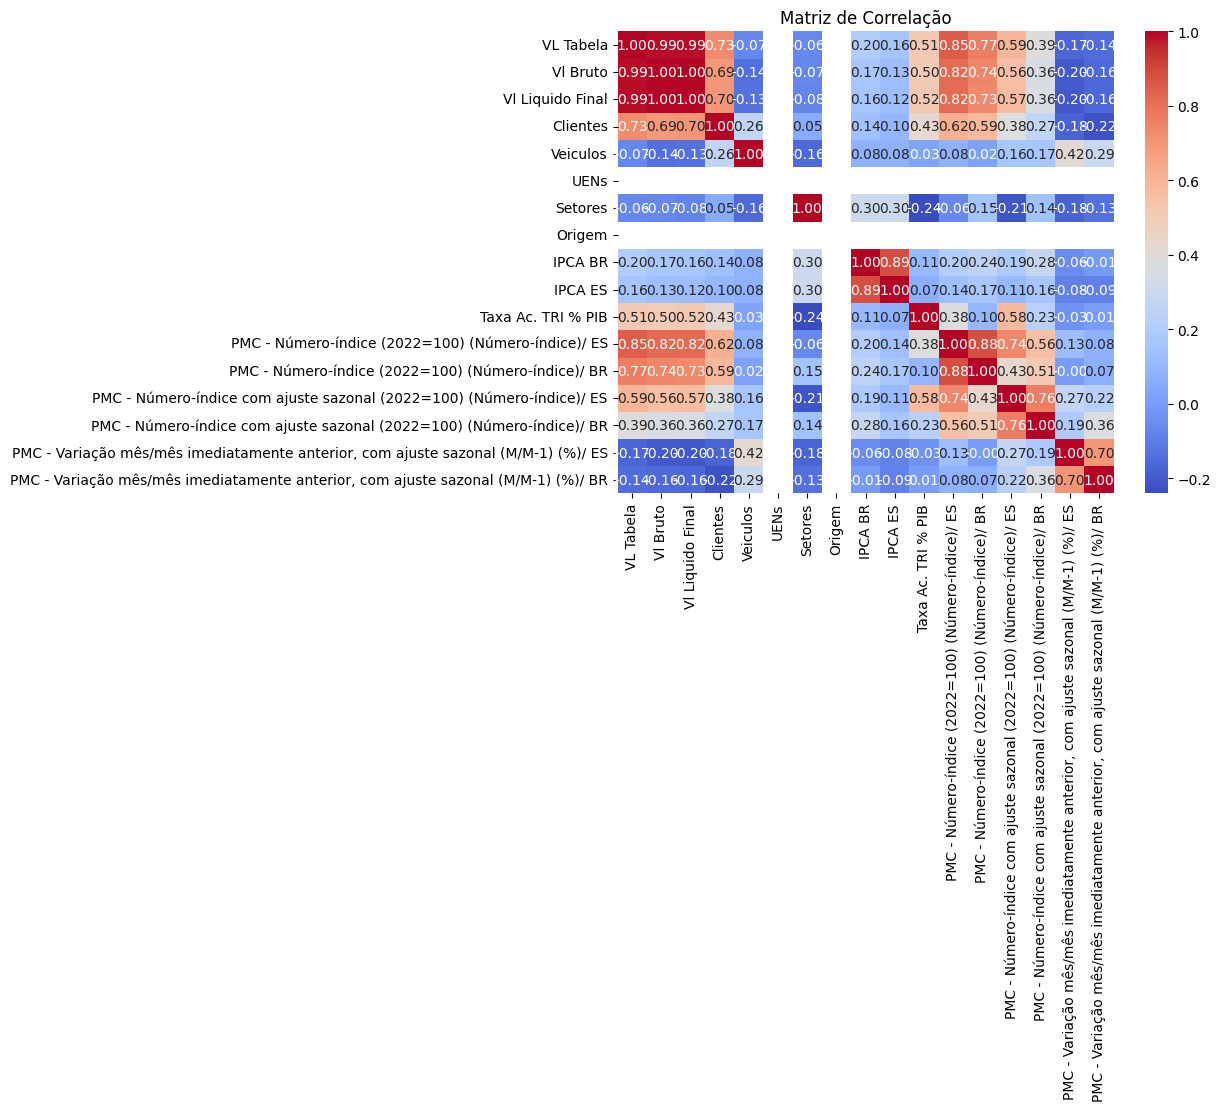

In [9]:
correlation_matrix = df_geral.corr()

# Exibindo a matriz de correlação com Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [10]:
df_geral_limpo = df_geral.drop(columns=['VL Tabela', 'Vl Bruto', 'Veiculos', 'UENs', 'Setores', 'Origem', 'IPCA BR', 'IPCA ES', 'PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ ES', 'PMC - Número-índice (2022=100) (Número-índice)/ BR', 'PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ ES', 'PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ BR', 'PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ BR'])

In [11]:
df_geral_limpo

,Vl Liquido Final,Clientes,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES
Data,,,,
2020-01-01,5393691.53,583,1.1,84.25384
2020-02-01,5751548.26,559,1.1,81.61827
2020-03-01,5894599.74,558,1.1,80.76074
2020-04-01,3931148.87,442,-1.7,66.43382
2020-05-01,3993915.02,371,-1.7,81.57634
2020-06-01,4500465.96,409,-1.7,83.31604
2020-07-01,4593350.65,448,-2.8,89.13238
2020-08-01,5238599.75,531,-2.8,90.26367
2020-09-01,5058580.11,512,-2.8,90.83188


In [12]:
df_geral_limpo.dtypes

Vl Liquido Final                                      float64
Clientes                                                int64
Taxa Ac. TRI % PIB                                    float64
PMC - Número-índice (2022=100) (Número-índice)/ ES    float64
dtype: object

In [13]:
df_geral_limpo.head()

,Vl Liquido Final,Clientes,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES
Data,,,,
2020-01-01,5393691.53,583,1.1,84.25384
2020-02-01,5751548.26,559,1.1,81.61827
2020-03-01,5894599.74,558,1.1,80.76074
2020-04-01,3931148.87,442,-1.7,66.43382
2020-05-01,3993915.02,371,-1.7,81.57634


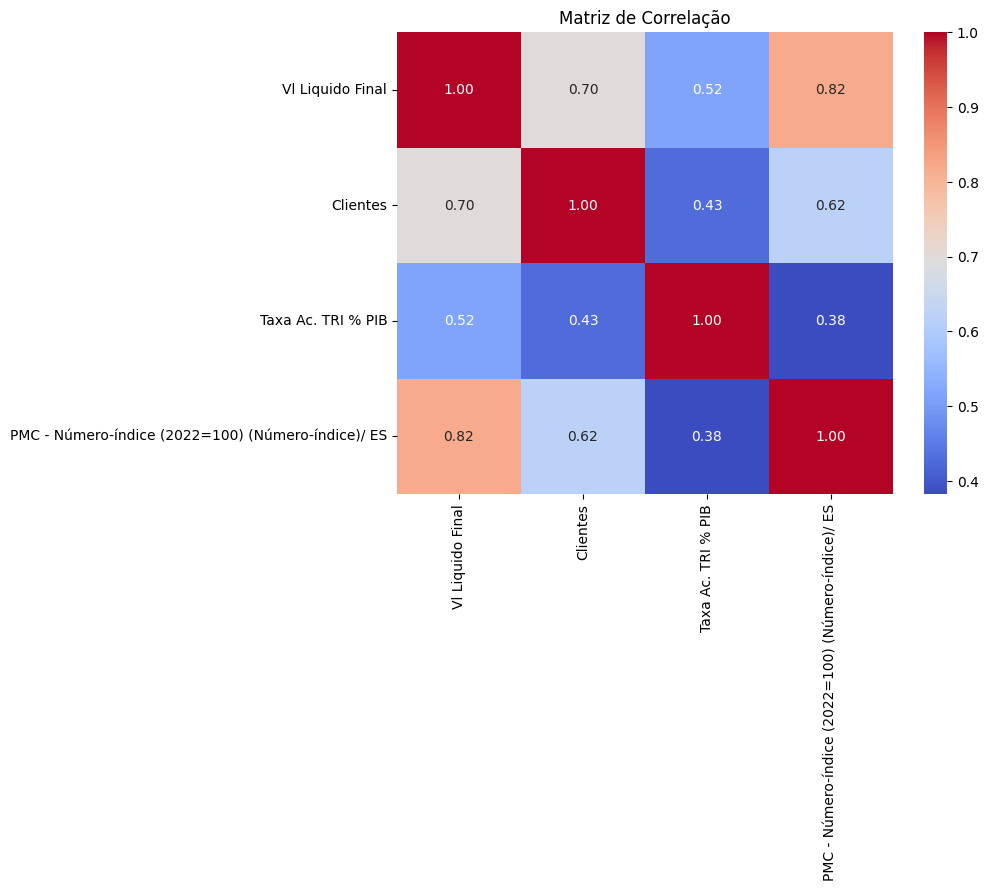

In [14]:
correlation_matrix = df_geral_limpo.corr()

# Exibindo a matriz de correlação com Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [15]:
df_geral_limpo['divisao'] = df_geral_limpo['Vl Liquido Final'].shift(1)

In [16]:
df_geral_limpo.fillna(5393691.53, inplace=True)

In [17]:
df_geral_limpo['dividido'] = df_geral_limpo['Vl Liquido Final']/df_geral_limpo['divisao']

<Axes: xlabel='Data'>

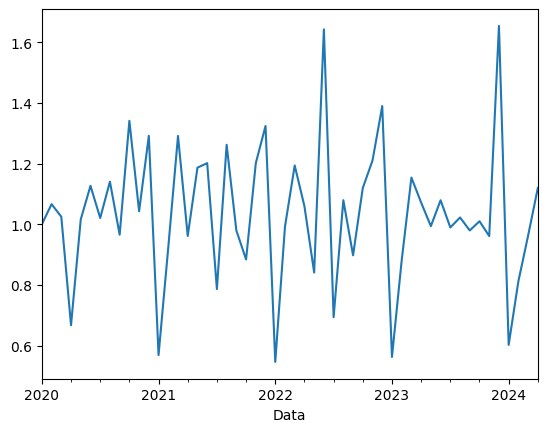

In [18]:
df_geral_limpo['dividido'].plot()

In [19]:
df_geral_limpo.describe()

,Vl Liquido Final,Clientes,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES,divisao,dividido
count,5.200000e+01,52.000000,52.000000,52.000000,5.200000e+01,52.000000
mean,7.624980e+06,575.076923,1.830769,96.646301,7.581254e+06,1.034536
std,2.164689e+06,87.508172,2.655039,10.690715,2.186667e+06,0.234824
min,3.931149e+06,371.000000,-3.300000,66.433820,3.931149e+06,0.545878
25%,6.271723e+06,517.000000,1.100000,90.393008,6.139971e+06,0.951753
50%,7.572099e+06,582.000000,2.700000,97.206125,7.453656e+06,1.021525
75%,8.763730e+06,627.750000,3.700000,100.268970,8.763730e+06,1.162205
max,1.454974e+07,754.000000,4.800000,122.543090,1.454974e+07,1.654318


In [20]:
X = df_geral_limpo.drop(columns=['Vl Liquido Final', 'divisao', 'dividido']) 
y = df_geral_limpo['dividido']

In [21]:
X.head()

,Clientes,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES
Data,,,
2020-01-01,583,1.1,84.25384
2020-02-01,559,1.1,81.61827
2020-03-01,558,1.1,80.76074
2020-04-01,442,-1.7,66.43382
2020-05-01,371,-1.7,81.57634


In [22]:
y.head()

Data
2020-01-01    1.000000
2020-02-01    1.066347
2020-03-01    1.024872
2020-04-01    0.666907
2020-05-01    1.015966
Name: dividido, dtype: float64

In [23]:
df_geral_limpo.dtypes

Vl Liquido Final                                      float64
Clientes                                                int64
Taxa Ac. TRI % PIB                                    float64
PMC - Número-índice (2022=100) (Número-índice)/ ES    float64
divisao                                               float64
dividido                                              float64
dtype: object

In [24]:
# Função para realizar a validação cruzada com janela deslizante
def rolling_window_cv(X, y, order, seasonal_order, steps=1, train_size=0.7):
    n = len(y)
    train_end = int(train_size * n)
    errors = []

    for i in range(train_end, n - steps):
        # Divida os dados até o ponto i para treinamento
        train_X, train_y = X[:i], y[:i]
        test_X, test_y = X[i:i + steps], y[i:i + steps]

        # Criar o modelo SARIMAX
        model = SARIMAX(train_y, exog=train_X, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)

        # Prever
        forecast = model_fit.forecast(steps=steps, exog=test_X)

        # Calcular o erro (exemplo: RMSE)
        rmse = np.sqrt(mean_squared_error(test_y, forecast))
        errors.append(rmse)

    return np.mean(errors)

In [25]:
# Divida os dados em treinamento e teste
train_size = int(len(y) * 0.7)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

In [26]:
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

print(f"Realizando otimização de hiperparâmetros para Colatina...")

# Definir a função objetivo para o Optuna
def objective(trial):
    # Hiperparâmetros do modelo SARIMA
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)
    # Aumentar o intervalo de P e Q para explorar melhor a sazonalidade
    P = trial.suggest_int('P', 0, 4)
    D = trial.suggest_int('D', 0, 2)
    Q = trial.suggest_int('Q', 0, 4)
    s = 6  # Período sazonal fixo em 12 (mensal)

    # Outras configurações do modelo
    trend = trial.suggest_categorical('trend', ['n', 'c', 't', 'ct'])
    measurement_error = trial.suggest_categorical('measurement_error', [True, False])

    try:
        # Criar o modelo SARIMA com os hiperparâmetros sugeridos
        model = SARIMAX(train_y, exog=train_X, order=(p, d, q), 
                        seasonal_order=(P, D, Q, s), trend=trend, 
                        measurement_error=measurement_error)

        # Ajustar o modelo
        model_fit = model.fit(disp=False)
        
        # Fazer previsões no conjunto de teste
        forecast_test = model_fit.forecast(steps=len(test_y), exog=test_X)
        
        # Calcular o erro quadrático médio (RMSE)
        rmse = np.sqrt(mean_squared_error(test_y, forecast_test))
    except Exception as e:
        # Em caso de erro na modelagem, retornar um valor grande
        print(f"Erro durante o ajuste do modelo: {e}")
        rmse = np.inf

    return rmse

# Criar o estudo Optuna e executar a otimização
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Obter os melhores hiperparâmetros
best_params = study.best_params
print("Melhores hiperparâmetros encontrados:")
print(best_params)


[I 2024-09-25 11:01:55,392] A new study created in memory with name: no-name-c4a00b21-2504-4419-bbf0-c7ee08290b67


Realizando otimização de hiperparâmetros para Colatina...


C:\Users\Raul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Raul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Raul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
[I 2024-0

Melhores hiperparâmetros encontrados:
{'p': 2, 'd': 0, 'q': 3, 'P': 4, 'D': 1, 'Q': 0, 'trend': 'c', 'measurement_error': False}


In [27]:
#model_best = SARIMAX(train_y, exog=train_X, order=(2, 1, 2), 
#                     seasonal_order=(1, 1, 4, 6))
#model_best_fit = model_best.fit(disp=False)

In [28]:
model_best = SARIMAX(train_y, exog=train_X, order=(best_params['p'], best_params['d'], best_params['q']), 
                     seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], 6))
model_best_fit = model_best.fit(disp=False)

C:\Users\Raul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Raul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Raul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Raul\AppData\Local\Packages\PythonSoftwareFoundation.P

In [29]:
# Previsão no conjunto de teste com o melhor modelo
forecast_test_best = model_best_fit.forecast(steps=len(test_y), exog=test_X)

# Previsão futura de 12 meses
future_steps = 12
future_dates = pd.date_range(start=test_y.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')
future_X = X.iloc[-future_steps:]  # Assumindo que você tenha dados futuros para as features

forecast_future_best = model_best_fit.forecast(steps=future_steps, exog=future_X)

# Combine previsões de teste e futuras
all_forecast_best = np.concatenate([forecast_test_best, forecast_future_best])
all_dates_best = test_y.index.append(future_dates)

C:\Users\Raul\AppData\Local\Temp\ipykernel_17900\3798967768.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=test_y.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')


In [30]:
test_y.describe()

count    16.000000
mean      0.990936
std       0.242193
min       0.562211
25%       0.940981
50%       0.991672
75%       1.073443
max       1.654318
Name: dividido, dtype: float64

In [31]:
test_X.tail()

,Clientes,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES
Data,,,
2023-12-01,630,2.9,116.66925
2024-01-01,477,2.5,99.47647
2024-02-01,436,2.5,92.67579
2024-03-01,467,2.5,103.20858
2024-04-01,527,2.5,98.85368


In [32]:
forecast_test_best.value_counts()

predicted_mean
0.634122    1
1.104765    1
1.125785    1
0.953574    1
0.992823    1
1.507602    1
0.676800    1
1.096646    1
0.994705    1
1.092564    1
1.088171    1
1.538851    1
0.635534    1
1.061703    1
1.033060    1
1.050188    1
Name: count, dtype: int64

In [33]:
forecast_test_best

2023-01-01    0.634122
2023-02-01    1.104765
2023-03-01    1.125785
2023-04-01    0.953574
2023-05-01    0.992823
2023-06-01    1.507602
2023-07-01    0.676800
2023-08-01    1.096646
2023-09-01    0.994705
2023-10-01    1.092564
2023-11-01    1.088171
2023-12-01    1.538851
2024-01-01    0.635534
2024-02-01    1.061703
2024-03-01    1.033060
2024-04-01    1.050188
Freq: MS, Name: predicted_mean, dtype: float64

Mean Absolute Error (MAE): 0.13
Root Mean Squared Error (RMSE): 0.17
Mean Absolute Percentage Error (MAPE): 13.13%
R-squared (R²): 0.47


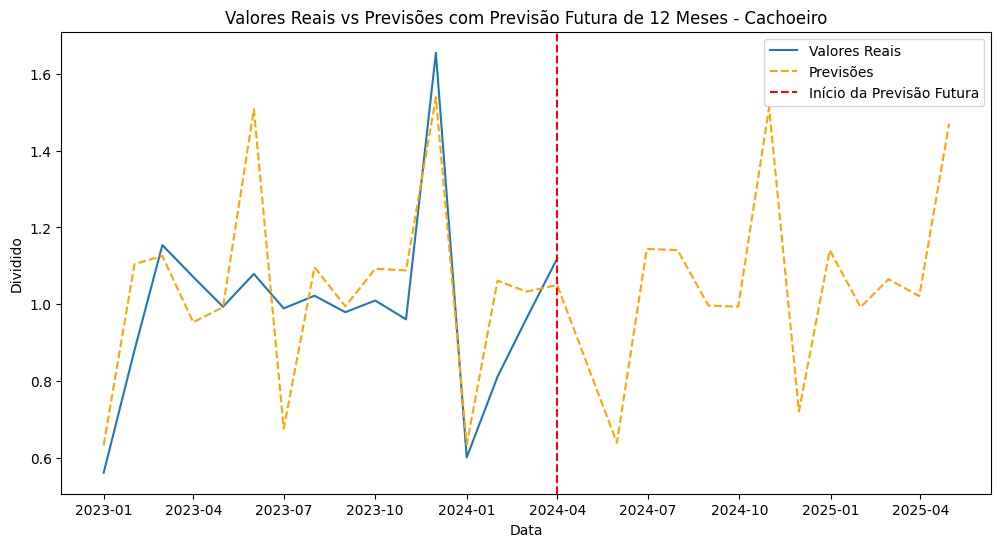

In [34]:


# Calcule as métricas de avaliação
mae = mean_absolute_error(test_y, forecast_test_best)
rmse = np.sqrt(mean_squared_error(test_y, forecast_test_best))
mape = np.mean(np.abs((test_y - forecast_test_best) / test_y)) * 100
r2 = r2_score(test_y, forecast_test_best)

# Exiba as métricas
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")

# Plotando os valores reais, as previsões e a previsão futura
plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y, label='Valores Reais')
plt.plot(all_dates_best, all_forecast_best, label='Previsões', linestyle='--', color='orange')
plt.axvline(x=test_y.index[-1], color='red', linestyle='--', label='Início da Previsão Futura')
plt.xlabel('Data')
plt.ylabel('Dividido')
plt.title(f'Valores Reais vs Previsões com Previsão Futura de 12 Meses - Cachoeiro')
plt.legend()
plt.show()

In [45]:
# Criar um DataFrame com as datas e previsões
df_forecast = pd.DataFrame({
    'Data': all_dates_best,             # Datas das previsões
    'Previsões': all_forecast_best      # Valores previstos
})

# Transformar a coluna 'Data' em DatetimeIndex (se ainda não for)
df_forecast['Data'] = pd.to_datetime(df_forecast['Data'])

# Definir a coluna 'Data' como índice
df_forecast.set_index('Data', inplace=True)

# Filtrar os dados até o mês 4 de 2024
df_filtrado = df_forecast.loc[:'2024-04-30']

# Exibir o DataFrame filtrado
df_filtrado.shape

(16, 1)

In [46]:
df_filtrado.head()

,Previsões
Data,
2023-01-01,0.634122
2023-02-01,1.104765
2023-03-01,1.125785
2023-04-01,0.953574
2023-05-01,0.992823


In [47]:
df_geral_limpo.head()

,Vl Liquido Final,Clientes,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES,divisao,dividido
Data,,,,,,
2020-01-01,5393691.53,583,1.1,84.25384,5393691.53,1.000000
2020-02-01,5751548.26,559,1.1,81.61827,5393691.53,1.066347
2020-03-01,5894599.74,558,1.1,80.76074,5751548.26,1.024872
2020-04-01,3931148.87,442,-1.7,66.43382,5894599.74,0.666907
2020-05-01,3993915.02,371,-1.7,81.57634,3931148.87,1.015966


In [51]:
df_geral_limpo.shape

(52, 6)

In [67]:
df_unido = df_geral_limpo.join(df_filtrado, how='outer')  # "inner" pega as datas comuns, "outer" pega todas

In [59]:
df_unido.shape

(16, 7)

In [68]:
df_unido.head(10)

,Vl Liquido Final,Clientes,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES,divisao,dividido,Previsões
Data,,,,,,,
2020-01-01,5393691.53,583,1.1,84.25384,5393691.53,1.000000,NaN
2020-02-01,5751548.26,559,1.1,81.61827,5393691.53,1.066347,NaN
2020-03-01,5894599.74,558,1.1,80.76074,5751548.26,1.024872,NaN
2020-04-01,3931148.87,442,-1.7,66.43382,5894599.74,0.666907,NaN
2020-05-01,3993915.02,371,-1.7,81.57634,3931148.87,1.015966,NaN
2020-06-01,4500465.96,409,-1.7,83.31604,3993915.02,1.126831,NaN
2020-07-01,4593350.65,448,-2.8,89.13238,4500465.96,1.020639,NaN
2020-08-01,5238599.75,531,-2.8,90.26367,4593350.65,1.140475,NaN
2020-09-01,5058580.11,512,-2.8,90.83188,5238599.75,0.965636,NaN


In [70]:
# Filtrando todas as datas a partir de 01/01/2023
df_filtrado = df_unido.loc['2022-12-01':]
df_filtrado.head()

,Vl Liquido Final,Clientes,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES,divisao,dividido,Previsões
Data,,,,,,,
2022-12-01,13920278.10,754,3.0,122.54309,10015395.32,1.389888,NaN
2023-01-01,7826132.91,491,3.7,100.20645,13920278.10,0.562211,0.634122
2023-02-01,6893743.21,481,3.7,89.79370,7826132.91,0.880862,1.104765
2023-03-01,7955439.80,543,3.7,106.02377,6893743.21,1.154009,1.125785
2023-04-01,8524340.55,572,3.7,95.24052,7955439.80,1.071511,0.953574


In [71]:
def calcula_previsto_faturado(df):
    # Preenche a coluna 'Previsto Faturado' com o 'Vl Liquido Final' do mês anterior multiplicado pela 'Previsões'
    df['Previsto Faturado'] = df['Vl Liquido Final'].shift(1) * df['Previsões']
    return df


In [74]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [75]:
# Calcula o previsto faturado
df_pf = calcula_previsto_faturado(df_filtrado)

# Exibe o DataFrame resultante
df_pf.head()

C:\Users\Raul\AppData\Local\Temp\ipykernel_17900\3730062096.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Previsto Faturado'] = df['Vl Liquido Final'].shift(1) * df['Previsões']


,Vl Liquido Final,Clientes,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES,divisao,dividido,Previsões,Previsto Faturado
Data,,,,,,,,
2022-12-01,13920278.10,754,3.00,122.54,10015395.32,1.39,NaN,NaN
2023-01-01,7826132.91,491,3.70,100.21,13920278.10,0.56,0.63,8827155.29
2023-02-01,6893743.21,481,3.70,89.79,7826132.91,0.88,1.10,8646035.77
2023-03-01,7955439.80,543,3.70,106.02,6893743.21,1.15,1.13,7760873.90
2023-04-01,8524340.55,572,3.70,95.24,7955439.80,1.07,0.95,7586099.32


In [78]:
df1 = df_pf.reset_index().rename(columns={'index': 'Data'})
df2 = df_geral.reset_index().rename(columns={'index': 'Data'})

# Converter a coluna 'Data' para o formato datetime para garantir que o merge funcione corretamente
df1['Data'] = pd.to_datetime(df1['Data'])
df2['Data'] = pd.to_datetime(df2['Data'])

# Realizar o merge com base na coluna 'Data'
df_merged = pd.merge(df2, df1[['Data', 'Previsto Faturado']], on='Data', how='left')

In [80]:
df_merged['Previsto Faturado'].value_counts()

Previsto Faturado
8827155.29     1
8646035.77     1
7760873.90     1
7586099.32     1
8463157.97     1
12771957.11    1
6187985.48     1
9921556.52     1
9200974.18     1
9899892.31     1
9958659.24     1
13534210.63    1
9246851.58     1
9300370.42     1
7348475.67     1
7191734.12     1
Name: count, dtype: int64

In [77]:
df_merged = pd.merge(df_pf, df_geral[['Data', 'Previsto Faturado']], on='Data', how='left')

df_merged.head()

KeyError: "None of [Index(['Data', 'Previsto Faturado'], dtype='object')] are in the [columns]"

In [ ]:
df_unido['Previsao VLF'] = df_unido

In [50]:
df_unido['Previsões'].value_counts()

Previsões
0.634122    1
1.104765    1
1.125785    1
0.953574    1
0.992823    1
1.507602    1
0.676800    1
1.096646    1
0.994705    1
1.092564    1
1.088171    1
1.538851    1
0.635534    1
1.061703    1
1.033060    1
1.050188    1
Name: count, dtype: int64

In [40]:
forecast_description = forecast_test_best.describe()
print(forecast_description)

count    16.000000
mean      1.036681
std       0.252954
min       0.634122
25%       0.983010
50%       1.055945
75%       1.098676
max       1.538851
Name: predicted_mean, dtype: float64


In [ ]:
# Filtrar os dados até o mês 4 de 2024
df_filtrado = df_results.loc[:'2024-04-30']

# Exibir o DataFrame filtrado
print(df_filtrado)

In [38]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Raul\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\prophet\\stan_model\\cmdstan-2.33.1\\stan\\lib\\stan_math\\lib\\tbb_2020.3\\include\\tbb\\internal\\_deprecated_header_message_guard.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: C:\Users\Raul\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



  Using cached prophet-1.1.5-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.2.4-py3-none-any.whl.metadata (4.1 kB)
  Using cached holidays-0.57-py3-none-any.whl.metadata (26 kB)
  Using cached importlib_resources-6.4.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.1.5-py3-none-win_amd64.whl (13.3 MB)
Using cached cmdstanpy-1.2.4-py3-none-any.whl (94 kB)
Using cached holidays-0.57-py3-none-any.whl (1.1 MB)
Using cached importlib_resources-6.4.5-py3-none-any.whl (36 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)


In [39]:
# Importar as bibliotecas necessárias
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preparar os dados para o Prophet
# O Prophet requer um DataFrame com duas colunas: 'ds' para datas e 'y' para valores
train_data = pd.DataFrame({'ds': train_X.index, 'y': train_y})
test_data = pd.DataFrame({'ds': test_X.index, 'y': test_y})

# Inicializar o modelo Prophet
model = Prophet()

# Adicionar as variáveis exógenas como 'regressor' no Prophet
model.add_regressor('Clientes')
model.add_regressor('Taxa Ac. TRI % PIB')
model.add_regressor('PMC - Número-índice (2022=100)')
model.add_regressor('(Número-índice)/ ES')

# Ajustar o modelo aos dados de treinamento
train_data['Clientes'] = train_X['Clientes'].values
train_data['Taxa Ac. TRI % PIB'] = train_X['Taxa Ac. TRI % PIB'].values
train_data['PMC - Número-índice (2022=100)'] = train_X['PMC - Número-índice (2022=100)'].values
train_data['(Número-índice)/ ES'] = train_X['(Número-índice)/ ES'].values

model.fit(train_data)

# Fazer previsões no conjunto de teste
future = test_data.copy()
future['Clientes'] = test_X['Clientes'].values
future['Taxa Ac. TRI % PIB'] = test_X['Taxa Ac. TRI % PIB'].values
future['PMC - Número-índice (2022=100)'] = test_X['PMC - Número-índice (2022=100)'].values
future['(Número-índice)/ ES'] = test_X['(Número-índice)/ ES'].values

forecast = model.predict(future)

# Calcular as métricas de avaliação
mae = mean_absolute_error(test_y, forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test_y, forecast['yhat']))
mape = np.mean(np.abs((test_y - forecast['yhat']) / test_y)) * 100
r2 = r2_score(test_y, forecast['yhat'])

# Exiba as métricas
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")

# Fazer previsões futuras
future_steps = 12
future_dates = pd.date_range(start=test_y.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')

# Preparar os dados futuros (para as variáveis exógenas também)
future_X = X.iloc[-future_steps:]

future_data = pd.DataFrame({'ds': future_dates})
future_data['Clientes'] = future_X['Clientes'].values
future_data['Taxa Ac. TRI % PIB'] = future_X['Taxa Ac. TRI % PIB'].values
future_data['PMC - Número-índice (2022=100)'] = future_X['PMC - Número-índice (2022=100)'].values
future_data['(Número-índice)/ ES'] = future_X['(Número-índice)/ ES'].values

forecast_future = model.predict(future_data)

# Plotando os valores reais, as previsões e a previsão futura
plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y, label='Valores Reais')
plt.plot(forecast['ds'], forecast['yhat'], label='Previsões', linestyle='--', color='orange')
plt.axvline(x=test_y.index[-1], color='red', linestyle='--', label='Início da Previsão Futura')
plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Previsão Futura', color='green')
plt.xlabel('Data')
plt.ylabel('Dividido')
plt.title('Valores Reais vs Previsões com Previsão Futura de 12 Meses - Cachoeiro')
plt.legend()
plt.show()


KeyError: 'PMC - Número-índice (2022=100)'